# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)


## Utility functions

### Plotting accuracy and loss

In [3]:
# function to plot the training/validation accuracies/losses.
import cv2
import matplotlib.pyplot as plt


def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [4]:
project_folder='/datasets/Project_data'

In [22]:
import abc
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def generator(self,source_path, folder_list, batch_size, augment=False):
    
#     img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
    #             batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3)) 
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
    #                     image = resize(image,(80,80)).astype(np.float32)
                        image = resize(image,(self.image_height,self.image_width)).astype(np.float32)
                        
                        # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)  
            
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
            # write the code for the remaining data points which are left after full batches
            if len(t) % batch_size != 0:
    #             batch_data = np.zeros((batch_size,13,80,80,3))
                batch_data = np.zeros((batch_size,len(img_idx),self.image_height,self.image_width,3))
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image = resize(image,(self.image_height,self.image_width)).astype(np.float32)
                        
                        # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                        if augment:
                            if np.random.randn() > 0:
                                image = datagen.random_transform(image)  
                        
                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does 


    def train_model(self, model, augment_data=False):
            train_generator = self.generator(self.train_path, self.train_doc, self.batch_size, augment=augment_data)
            val_generator = self.generator(self.val_path, self.val_doc, self.batch_size)

            model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

            if not os.path.exists(model_name):
                os.mkdir(model_name)

            filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
            LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

            earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
            callbacks_list = [checkpoint, LR, earlystop]

            if (self.num_train_sequences%self.batch_size) == 0:
                steps_per_epoch = int(self.num_train_sequences/self.batch_size)
            else:
                steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

            if (self.num_val_sequences%self.batch_size) == 0:
                validation_steps = int(self.num_val_sequences/self.batch_size)
            else:
                validation_steps = (self.num_val_sequences//self.batch_size) + 1

#             history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
#                                 callbacks=callbacks_list, validation_data=val_generator, 
#                                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
            return history


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: Set the Batch size to 64 and Epochs to 20. Image resolution to 120


Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:

class Model(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [7]:
conv_model_obj=Model()
conv_model_obj.initialize_path(project_folder)
conv_model_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model_obj.initialize_hyperparams(frames_to_sample=13,batch_size=64,num_epochs=20)
conv_model_model=conv_model_obj.define_model()
conv_model_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 13, 120, 120, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 13, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 60, 60, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 60, 60, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 60, 60, 64)     0

2025-01-29 14:53:07.845082: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-29 14:53:07.845155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [8]:
print("Total Params:", conv_model_model.count_params())

Total Params: 3781509


In [130]:
training_output_model = conv_model_obj.train_model(conv_model_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.4702
Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2025-01-2819_51_12.870779/model-00001-1.53871-0.47017-1.59490-0.22656.h5
11/11 [==============================] - 81s 8s/step - loss: 1.5387 - categorical_accuracy: 0.4702 - val_loss: 1.5949 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9710 - categorical_accuracy: 0.6278
Epoch 00002: val_loss did not improve from 1.59490
11/11 [==============================] - 78s 8s/step - loss: 0.9710 - categorical_accuracy: 0.6278 - val_loss: 1.7473 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7912
Epoch 00003: val_loss did not improve from 1.59490
11/11 [==============================] - 81s 8s/step - loss: 0.5936 - categorical_accuracy: 0.79

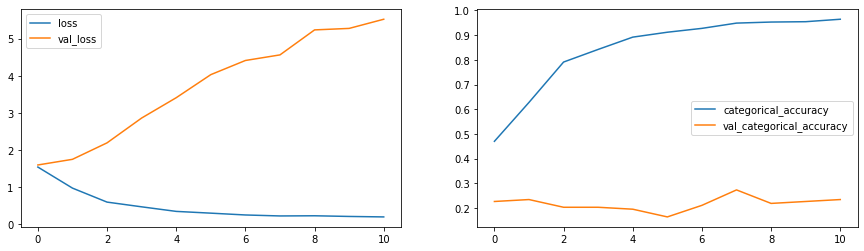

In [139]:
plot(training_output_model2)

## Model 2:  Reduce the Batch Size to 40 also reduce the Image resolution to (80 x 80). 

In [84]:

class Model2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [85]:
conv_model2_obj=Model2()
conv_model2_obj.initialize_path(project_folder)
conv_model2_obj.initialize_image_properties(image_height=80,image_width=80)
conv_model2_obj.initialize_hyperparams(frames_to_sample=13,batch_size=40,num_epochs=15)
conv_model2_model=conv_model2_obj.define_model()
conv_model2_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_34 (Activation)  (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_93 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 6, 40, 40, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_35 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_35 (Activation)  (None, 6, 40, 40, 64)   

In [86]:
print("Total Params:", conv_model2_model.count_params())

Total Params: 1733509


In [65]:
training_output_model2 = conv_model2_obj.train_model(conv_model2_model)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.7835 - categorical_accuracy: 0.3824
Epoch 00001: val_loss improved from inf to 1.60217, saving model to model_init_2025-01-2912_12_25.259404/model-00001-1.78351-0.38235-1.60217-0.18333.h5
17/17 [==============================] - 74s 5s/step - loss: 1.7835 - categorical_accuracy: 0.3824 - val_loss: 1.6022 - val_categorical_accuracy: 0.1833 - lr: 0.0100
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1433 - categorical_accuracy: 0.5632
Epoch 00002: val_loss did not improve from 1.60217
17/17 [==============================] - 73s 5s/step - loss: 1.1433 - categorical_accuracy: 0.5632 - val_loss: 1.8758 - val_categorical_accuracy: 0.2417 - lr: 0.0100
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8684 - categorical_accuracy: 0.6794
Epoch 00003: val_loss did not improve from 1.60217
17/17 [==============================] - 71s 4s/step - loss: 0.8684 - categorical_accuracy: 0.67

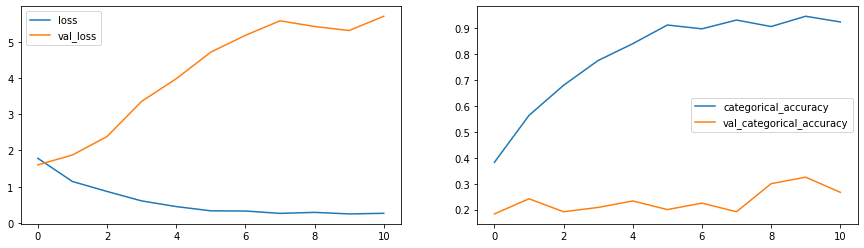

In [66]:
plot(training_output_model2)

Our model is seemingly **Overfitting.**

## Model 3: Data Augmentation and frames_per_sample 20

The model is seemingly **Overfitting.** So, let us do some ***data augmentation***, increase the frames per second to be considered and run the training.

In [20]:

class Model3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_model3_obj=Model3()
conv_model3_obj.initialize_path(project_folder)
conv_model3_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model3_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=15)
conv_model3_model=conv_model3_obj.define_model()
conv_model3_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_17 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 64)   

In [22]:
print("Total Params:", conv_model3_model.count_params())

Total Params: 7467909


In [149]:
training_output_model3 = conv_model3_obj.train_model(conv_model3_model, augment_data=True)

Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.4205 
Epoch 00001: val_loss improved from inf to 1.64988, saving model to model_init_2025-01-2820_33_44.740223/model-00001-1.60700-0.42045-1.64988-0.30469.h5
11/11 [==============================] - 148s 15s/step - loss: 1.6070 - categorical_accuracy: 0.4205 - val_loss: 1.6499 - val_categorical_accuracy: 0.3047 - lr: 0.0100
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.0145 - categorical_accuracy: 0.6207 
Epoch 00002: val_loss did not improve from 1.64988
11/11 [==============================] - 136s 14s/step - loss: 1.0145 - categorical_accuracy: 0.6207 - val_loss: 2.0183 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.8197 - categorical_accuracy: 0.6903 
Epoch 00003: val_loss did not improve from 1.64988
11/11 [==============================] - 136s 14s/step - loss: 0.8197 - categorical_accur

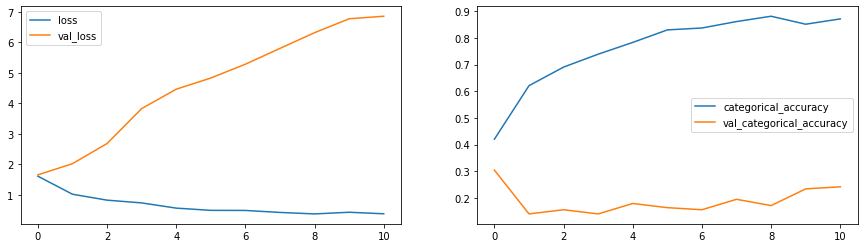

In [150]:
plot(training_output_model3)

## Model 4: Changing the filter size to (2x2x2). Maintaining the Image Resolution at 120x120 and increase Frames_per_sample 20


In [9]:

class Model4(ModelBuilder):
    
    def define_model(self,filtersize=(2,2,2),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(5,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_model4_obj=Model4()
conv_model4_obj.initialize_path(project_folder)
conv_model4_obj.initialize_image_properties(image_height=80,image_width=80)
conv_model4_obj.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=20)
conv_model4_model=conv_model4_obj.define_model()
conv_model4_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 80, 80, 32)    2624      
                                                                 
 activation_3 (Activation)   (None, 30, 80, 80, 32)    0         
                                                                 
 batch_normalization_5 (Batc  (None, 30, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 40, 40, 64)    16448     
                                                                 
 activation_4 (Activation)   (None, 15, 40, 40, 64)   

In [11]:
print("Total Params:", conv_model4_model.count_params())

Total Params: 5010309


In [144]:
training_output_model4 = conv_model4_obj.train_model(conv_model4_model)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.3783 - categorical_accuracy: 0.4851
Epoch 00001: val_loss improved from inf to 5.74708, saving model to model_init_2025-01-2914_18_28.044206/model-00001-1.37828-0.48512-5.74708-0.14062.h5
21/21 [==============================] - 165s 8s/step - loss: 1.3783 - categorical_accuracy: 0.4851 - val_loss: 5.7471 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.7271 - categorical_accuracy: 0.7247
Epoch 00002: val_loss did not improve from 5.74708
21/21 [==============================] - 165s 8s/step - loss: 0.7271 - categorical_accuracy: 0.7247 - val_loss: 11.9022 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5094 - categorical_accuracy: 0.8155
Epoch 00003: val_loss did not improve from 5.74708
21/21 [==============================] - 164s 8s/step - loss: 0.5094 - categorical_accuracy: 

In [12]:
plot(training_output_model4)

NameError: name 'training_output_model4' is not defined

## Model 5: Adding more Layers


 As part of further experimentation, lets add more layers and check the accuracy. We will keep the image size as 120 x 120 with epoch=20

In [41]:

class Model5(ModelBuilder):
       
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "Adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_model5_obj=Model5()
conv_model5_obj.initialize_path(project_folder)
conv_model5_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model5_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model5_model=conv_model5_obj.define_model()
conv_model5_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_9 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_32 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_10 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_33 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                     

In [43]:
print("Total Params:", conv_model5_model.count_params())

Total Params: 1287989


In [44]:
training_output_model5 = conv_model5_obj.train_model(conv_model5_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5975 - categorical_accuracy: 0.3693
Epoch 00001: val_loss improved from inf to 1.58400, saving model to model_init_2025-01-2910_14_58.922982/model-00001-1.59747-0.36932-1.58400-0.27344.h5
11/11 [==============================] - 123s 11s/step - loss: 1.5975 - categorical_accuracy: 0.3693 - val_loss: 1.5840 - val_categorical_accuracy: 0.2734 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.1662 - categorical_accuracy: 0.5355
Epoch 00002: val_loss did not improve from 1.58400
11/11 [==============================] - 117s 12s/step - loss: 1.1662 - categorical_accuracy: 0.5355 - val_loss: 1.6102 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.9447 - categorical_accuracy: 0.6477
Epoch 00003: val_loss did not improve from 1.58400
11/11 [==============================] - 115s 11s/step - loss: 0.9447 - categorical_accuracy

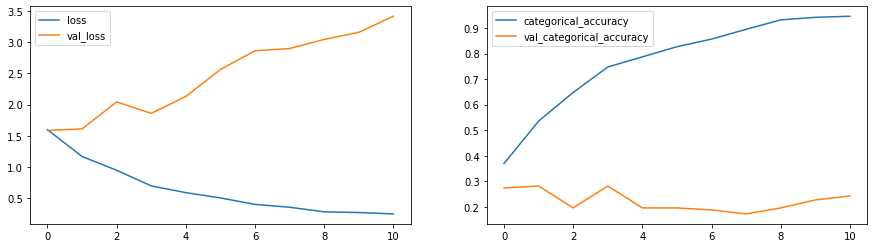

In [45]:
plot(training_output_model5)

## Model 6: Adding Drop outs to convolution layer


In above model we see the validation accuracy is varing wildly. Adding more epochs may give the stable validation accuracy. we would try to add dropouts to convolution layer to see if there are improvements

In [46]:

class Model6(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
  
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_model6_obj=Model6()
conv_model6_obj.initialize_path(project_folder)
conv_model6_obj.initialize_image_properties(image_height=120,image_width=120)
conv_model6_obj.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=20)
conv_model6_model=conv_model6_obj.define_model()
conv_model6_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_17 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_18 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_18 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                     

In [48]:
print("Total Params:", conv_model6_model.count_params())

Total Params: 1287989


In [49]:
training_output_model6 = conv_model6_obj.train_model(conv_model6_model)

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.7898 - categorical_accuracy: 0.3381
Epoch 00001: val_loss improved from inf to 1.72811, saving model to model_init_2025-01-2910_42_47.769482/model-00001-1.78975-0.33807-1.72811-0.17188.h5
11/11 [==============================] - 116s 11s/step - loss: 1.7898 - categorical_accuracy: 0.3381 - val_loss: 1.7281 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3402 - categorical_accuracy: 0.4730
Epoch 00002: val_loss did not improve from 1.72811
11/11 [==============================] - 115s 11s/step - loss: 1.3402 - categorical_accuracy: 0.4730 - val_loss: 1.7561 - val_categorical_accuracy: 0.1406 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.1339 - categorical_accuracy: 0.5810
Epoch 00003: val_loss improved from 1.72811 to 1.58565, saving model to model_init_2025-01-2910_42_47.769482/model-00003-1.13391-0.58097-1.5856

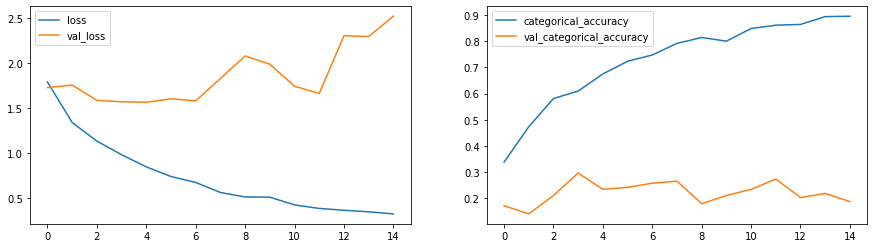

In [50]:
plot(training_output_model6)

## Model 7: CNN + LSTM


In above model we see the validation accuracy is varing wildly. We will try to change the architecture to have CNN + LSTM. We will use an image size of 120 x 120 and a batch size of 20

In [65]:
from keras.layers.recurrent import LSTM


class CNNLSTM(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
#         optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
  
     

In [66]:
cnn_lstm=CNNLSTM()
cnn_lstm.initialize_path(project_folder)
cnn_lstm.initialize_image_properties(image_height=120,image_width=120)
cnn_lstm.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
cnn_lstm_model=cnn_lstm.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_269 (TimeD  (None, 18, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_270 (TimeD  (None, 18, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_271 (TimeD  (None, 18, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_272 (TimeD  (None, 18, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_273 (TimeD  (None, 18, 60, 60, 32) 

In [16]:
print("Total Params:", cnn_lstm_model.count_params())

Total Params: 1657445


In [175]:
training_output_model7 = cnn_lstm.train_model(cnn_lstm_model)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.5693 - categorical_accuracy: 0.8423
Epoch 00001: val_loss improved from inf to 1.69906, saving model to model_init_2025-01-2821_33_36.941985/model-00001-0.56926-0.84226-1.69906-0.35938.h5
21/21 [==============================] - 100s 5s/step - loss: 0.5693 - categorical_accuracy: 0.8423 - val_loss: 1.6991 - val_categorical_accuracy: 0.3594 - lr: 0.0020
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5552 - categorical_accuracy: 0.8363
Epoch 00002: val_loss did not improve from 1.69906
21/21 [==============================] - 107s 5s/step - loss: 0.5552 - categorical_accuracy: 0.8363 - val_loss: 1.7089 - val_categorical_accuracy: 0.3359 - lr: 0.0020
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5452 - categorical_accuracy: 0.8497
Epoch 00003: val_loss did not improve from 1.69906
21/21 [==============================] - 105s 5s/step - loss: 0.5452 - categorical_accuracy: 0

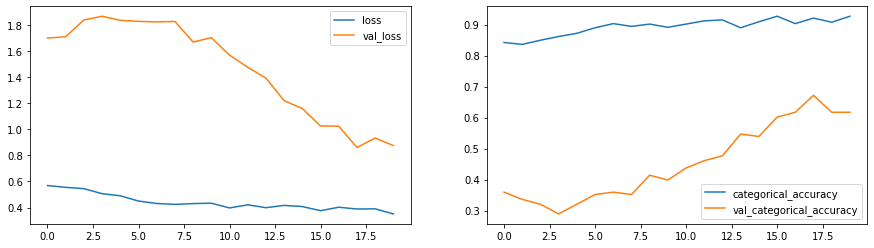

In [176]:
plot(training_output_model7)

## Model 8: CNN + LSTM with epochs = 25


In above model we see the validation accuracy is varing wildly. We will try to change the architecture to have CNN + LSTM. We will use an image size of 120 x 120 and epochs =  25

In [68]:
cnn_lstm2=CNNLSTM()
cnn_lstm2.initialize_path(project_folder)
cnn_lstm2.initialize_image_properties(image_height=80,image_width=80)
cnn_lstm2.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=25)
cnn_lstm2_model=cnn_lstm2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
cnn_lstm2_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_301 (TimeD  (None, 20, 80, 80, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_302 (TimeD  (None, 20, 80, 80, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_303 (TimeD  (None, 20, 40, 40, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_304 (TimeD  (None, 20, 40, 40, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_305 (TimeD  (None, 20, 40, 40, 32) 

In [69]:
print("Total Params:", cnn_lstm2_model.count_params())

Total Params: 1002085


In [ ]:
training_output_model8 = cnn_lstm2.train_model(cnn_lstm2_model)

Epoch 1/25
 2/21 [=>............................] - ETA: 1:19 - loss: 1.6667 - categorical_accuracy: 0.2031

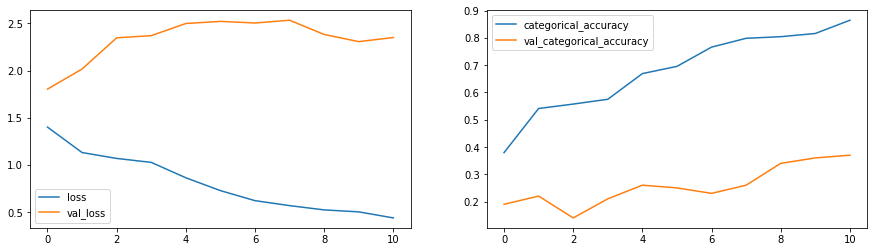

In [51]:
plot(training_output_model8)

## Model 9: CNN + LSTM with GRU


In the above Model, we see sign of improvement in training and validation accuracy. They seem to be converging together. We will increase the image resolution to and use GRU along with CNN and LSTM with increased Epochs.

We hope to see an Improvement in training Time as GRU trains fewere parameters compared to LSTM

In [30]:
from keras.layers import GRU

class GRULSTM(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [31]:
gru_lstm=GRULSTM()
gru_lstm.initialize_path(project_folder)
gru_lstm.initialize_image_properties(image_height=120,image_width=120)
gru_lstm.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=30)
gru_lstm_model=gru_lstm.define_model()
gru_lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 30, 60, 60, 32)  

In [32]:
print("Total Params:", gru_lstm_model.count_params())

Total Params: 1319781


In [33]:
training_output_model9 = gru_lstm.train_model(gru_lstm_model)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5661 - categorical_accuracy: 0.3155
Epoch 00001: val_loss improved from inf to 1.82308, saving model to model_init_2025-01-2915_17_09.339672/model-00001-1.56606-0.31548-1.82308-0.28906.h5
21/21 [==============================] - 167s 8s/step - loss: 1.5661 - categorical_accuracy: 0.3155 - val_loss: 1.8231 - val_categorical_accuracy: 0.2891 - lr: 0.0020
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.3393 - categorical_accuracy: 0.4122
Epoch 00002: val_loss did not improve from 1.82308
21/21 [==============================] - 166s 8s/step - loss: 1.3393 - categorical_accuracy: 0.4122 - val_loss: 2.2732 - val_categorical_accuracy: 0.2188 - lr: 0.0020
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.2471 - categorical_accuracy: 0.4717
Epoch 00003: val_loss did not improve from 1.82308
21/21 [==============================] - 167s 8s/step - loss: 1.2471 - categorical_accuracy: 0

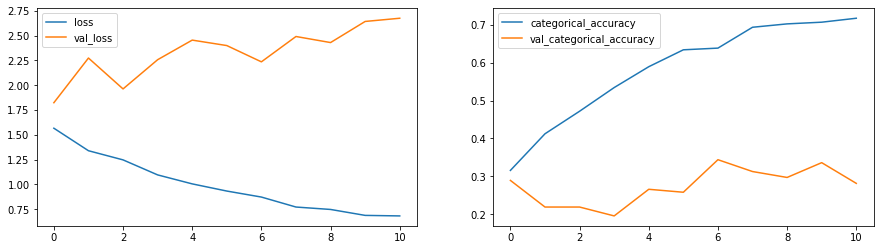

In [34]:
plot(training_output_model9)

In the above Model, we see sign of improvement in training and validation accuracy. They seem to be converging together. 

## Model 10: Transfer Learning using Mobilenet with GRU


We will Try and use transfer learning to see if there is improvement in training time and validation accuracy. We will mobilenet as our initial model

In [56]:

from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class GRUTransferLearning(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
gru_tl=GRUTransferLearning()
gru_tl.initialize_path(project_folder)
gru_tl.initialize_image_properties(image_height=120,image_width=120)
gru_tl.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
gru_tl_model=gru_tl.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
gru_tl_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_182 (TimeD  (None, 16, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_183 (TimeD  (None, 16, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_184 (TimeD  (None, 16, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_185 (TimeD  (None, 16, 1024)         0         
 istributed)                                                     
                                                                 
 gru_8 (GRU)                 (None, 128)             

In [61]:
print("Total Params:", gru_tl_model.count_params())

Total Params: 3693253


In [62]:
training_output_model9 = gru_tl.train_model(gru_tl_model)

Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 0.8974 - categorical_accuracy: 0.6435
Epoch 00001: val_loss improved from inf to 0.64465, saving model to model_init_2025-01-2906_15_34.177975/model-00001-0.89745-0.64348-0.64465-0.77500.h5
23/23 [==============================] - 97s 4s/step - loss: 0.8974 - categorical_accuracy: 0.6435 - val_loss: 0.6446 - val_categorical_accuracy: 0.7750 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 0.3662 - categorical_accuracy: 0.8551
Epoch 00002: val_loss improved from 0.64465 to 0.30795, saving model to model_init_2025-01-2906_15_34.177975/model-00002-0.36621-0.85507-0.30795-0.90000.h5
23/23 [==============================] - 90s 4s/step - loss: 0.3662 - categorical_accuracy: 0.8551 - val_loss: 0.3080 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 0.1635 - categorical_accuracy: 0.9420
Epoch 00003: val_loss did not improve from

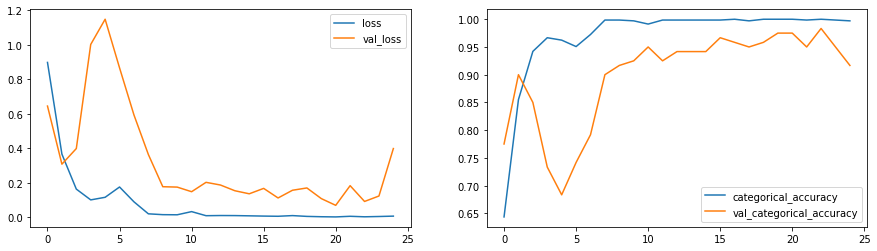

In [67]:
plot(training_output_model9)